# Connect 4

---

Author: S. Menary [sbmenary@gmail.com]

Date  : 2023-01-15, last edit 2023-01-17

Brief : Develop a bot using a neural network bot with Monte Carlo Tree Search (MCTS)

---

## Notes

- apply random reflections to exploit parity symmetry
- represent all inputs from perspective of current player, so +1 for self and -1 for other

## Imports

In [1]:
###
###  Required imports
###  - all imports should be placed here
###


##  Python core libs
import sys, time

##  PyPI libs
import numpy as np
from matplotlib import pyplot as plt

##  Local packages
from connect4.utils    import DebugLevel
from connect4.game     import BinaryPlayer, GameBoard, GameResult
from connect4.MCTS     import Node_NeuralMCTS
from connect4.bot      import Bot_NeuralMCTS, Bot_VanillaMCTS
from connect4.parallel import MonitorThread, WorkerThread, kill_threads


In [2]:
###
###  Print version for reproducibility
###

print(f"{'Python'    .rjust(12)} version is {sys.version}")
print(f"{'Numpy'     .rjust(12)} version is {np.__version__}")


      Python version is 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:29) [Clang 14.0.6 ]
       Numpy version is 1.23.2


In [3]:

def get_training_data_from_bot_game(model, duration:int=1, discount=1., debug_lvl:DebugLevel=DebugLevel.MUTE) :
    ##  Create game and bot
    game_board = GameBoard()
    bot        = Bot_NeuralMCTS(model) if model else Bot_VanillaMCTS()
    debug_lvl.message(DebugLevel.LOW, f"Using bot {bot}")
    debug_lvl.message(DebugLevel.LOW, game_board)

    ##  Create containers for model input and output
    model_inputs, posteriors, values = [], [], []

    ##  Take moves until end of game, storing model in and target out at each turn
    ##  - values currently equal to +1 if the move is player X and -1 for player O
    ##  -  N.B. we do not invert sign of model_input because this already done by root_node
    result = game_board.get_result()
    while not result :
        bot.take_move(game_board, duration=duration, discount=discount, debug_lvl=debug_lvl)
        debug_lvl.message(DebugLevel.LOW, game_board)
        if model : model_input = bot.root_node.model_input
        else : model_input = bot.root_node.game_board.board.reshape((game_board.horizontal_size, game_board.vertical_size, 1))
        model_inputs.append(model_input)
        posteriors  .append(bot.root_node.get_posterior_policy())
        values      .append(1.)
        result = game_board.get_result()
        
    ##  Resolve values
    backprop_value = result.get_game_score_for_player(BinaryPlayer.X)
    for idx in range(len(values)) :
        values[-1-idx]  = backprop_value
        backprop_value *= discount

    ##  Return containers as np arrays
    return np.array(model_inputs), np.array(posteriors), np.array(values).reshape((len(values),1))


##  Small board

In [4]:

##  Create game board
game_board = GameBoard(3, 3, 3)
game_board.apply_action(1)

##  Show updated game state
print(f"\nAfter a few moves:\n{game_board}")



After a few moves:
+---+---+---+
| . | . | . |
| . | . | . |
| . | X | . |
+---+---+---+
| 0 | 1 | 2 |
+---+---+---+
Game result is: NONE


In [5]:
'''###
###  Perform a few MCTS steps
###  - transitions into a ciritical state where O player needs to be careful not to 
###    blunder a win for X
###

##  Create a root node at the current game state
model     = create_model(game_board.board.shape)
root_node = Node_NeuralMCTS(game_board, params=[model, 1.], label="ROOT")

##  Print the initial value tree (should be a ROOT node with no children)
print("Initial tree:")
print(root_node.tree_summary())
print()

##  Perform several MCTS steps with a HIGH debug level
root_node.multi_step_MCTS(num_steps=10, max_sim_steps=-1, discount=0.99, debug_lvl=DebugLevel.MEDIUM)

##  Print the updated value tree 
print("Updated tree:")
print(root_node.tree_summary())
print()
'''

'###\n###  Perform a few MCTS steps\n###  - transitions into a ciritical state where O player needs to be careful not to \n###    blunder a win for X\n###\n\n##  Create a root node at the current game state\nmodel     = create_model(game_board.board.shape)\nroot_node = Node_NeuralMCTS(game_board, params=[model, 1.], label="ROOT")\n\n##  Print the initial value tree (should be a ROOT node with no children)\nprint("Initial tree:")\nprint(root_node.tree_summary())\nprint()\n\n##  Perform several MCTS steps with a HIGH debug level\nroot_node.multi_step_MCTS(num_steps=10, max_sim_steps=-1, discount=0.99, debug_lvl=DebugLevel.MEDIUM)\n\n##  Print the updated value tree \nprint("Updated tree:")\nprint(root_node.tree_summary())\nprint()\n'

In [6]:
'''
##  Use MCTS to search for an optimal action
game_board = GameBoard(4, 4, 3)
bot = Bot_NeuralMCTS(model)

while not game_board.get_result() :
    action = bot.choose_action(game_board, duration=5, discount=0.99, debug_lvl=DebugLevel.LOW)
    game_board.apply_action(action)
    print(game_board)
    '''

'\n##  Use MCTS to search for an optimal action\ngame_board = GameBoard(4, 4, 3)\nbot = Bot_NeuralMCTS(model)\n\nwhile not game_board.get_result() :\n    action = bot.choose_action(game_board, duration=5, discount=0.99, debug_lvl=DebugLevel.LOW)\n    game_board.apply_action(action)\n    print(game_board)\n    '

## Multiprocess datapoint generation

In [7]:

def create_model_process(proc_idx, num_games, out_queue, model_name, optimizer="adam") :
    from connect4.neural import create_model
    model = create_model(name=model_name, optimizer=optimizer)
    model.save(model_name)
    out_queue.put(True)
    
def create_model_in_process(model_name, optimizer="adam") :
    worker = WorkerThread(create_model_process, 1, 1, func_args=[model_name, optimizer])
    worker.start()
    worker.join()


In [8]:

def generate_datapoints_process(proc_idx, num_games, out_queue, base_seed, model_name, duration, discount) :
    from connect4.neural import load_model
    np.random.seed(base_seed+proc_idx)
    model = None
    if len(model_name) > 0 :
        model = load_model(model_name)
    for game_idx in range(num_games) :
        _ = get_training_data_from_bot_game(model, duration, discount)
        out_queue.put(_)
                
def generate_datapoints(num_processes, num_games_per_proc, base_seed, model_name, duration, discount, mon_freq=3) :
    worker  = WorkerThread(generate_datapoints_process, num_processes, num_games_per_proc, 
                       func_args=[base_seed, model_name, duration, discount])
    monitor = MonitorThread(worker, frequency=mon_freq)

    monitor.start()
    worker .start()

    worker .join()
    monitor.join()
    
    return worker.results


In [11]:
###
###  Generate training data
###

num_processes      = 6
num_games_per_proc = 100
base_seed          = 10
duration           = 1
discount           = 0.99
monitor_frequency  = 3

new_model_itr  = 1
old_model_name = f".neural_model_v{new_model_itr-1}.h5" if new_model_itr>1 else ""

'''results = generate_datapoints(num_processes, num_games_per_proc, base_seed, old_model_name, 
                              duration, discount, monitor_frequency)
                              
##  Retrieve training data from worker thread

model_in = np.concatenate([r[0] for r in results])
model_p  = np.concatenate([r[1] for r in results])
model_v  = np.concatenate([r[2] for r in results])'''


'results = generate_datapoints(num_processes, num_games_per_proc, base_seed, old_model_name, \n                              duration, discount, monitor_frequency)\n                              \n##  Retrieve training data from worker thread\n\nmodel_in = np.concatenate([r[0] for r in results])\nmodel_p  = np.concatenate([r[1] for r in results])\nmodel_v  = np.concatenate([r[2] for r in results])'

In [12]:
kill_threads()

In [84]:
import pickle

loaded = pickle.load(open(".training_data.pickle", "rb"))
model_in, model_p, model_v = loaded["model_in"], loaded["model_p"], loaded["model_v"]

In [85]:

print(len(model_in))
print(model_in.shape)
print(model_p .shape)
print(model_v .shape)

##  Randomly flip board in x-direction to created augmented dataset reflecting game symmetry
##  Make sure we also flip the posterior policy

for idx in range(len(model_in)) :
    if np.random.choice([True, False]) : continue
    model_in[idx] = np.flip(model_in[idx], axis=0)
    model_p [idx] = np.flip(model_p [idx], axis=0)

##  Shuffle
indices = np.arange(len(model_in))
np.random.shuffle(indices)

model_in = model_in[indices]
model_p  = model_p [indices]
model_v  = model_v [indices]

num_datapoints = len(model_in)
split_idx = int(0.7*num_datapoints)


9285
(9285, 7, 6, 1)
(9285, 7)
(9285, 1)


In [86]:

train_model_in = model_in[:split_idx]
train_model_p  = model_p [:split_idx]
train_model_v  = model_v [:split_idx]

val_model_in = model_in[split_idx:]
val_model_p  = model_p [split_idx:]
val_model_v  = model_v [split_idx:]


In [87]:
'''import pickle

to_save = {"model_in":model_in, "model_p":model_p, "model_v":model_v}
pickle.dump(to_save, open(f".training_data_v{new_model_itr}.pickle", "wb"))'''


'import pickle\n\nto_save = {"model_in":model_in, "model_p":model_p, "model_v":model_v}\npickle.dump(to_save, open(f".training_data_v{new_model_itr}.pickle", "wb"))'

In [106]:

from tensorflow.keras.layers import Add, BatchNormalization, Concatenate, Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, Softmax
from tensorflow.keras.losses import Loss, MeanSquaredError, CategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_model(board_size=(7, 6), num_filters=10, num_conv_blocks=3, batch_norm=True, max_pool=False, skip_connect=True,
                 kernel_size=(3,3), dropout=0.1, dense_width=100, num_dense=2,  optimizer="sgd", name=None) :
    
    inp = Input((board_size[0], board_size[1], 1), name="game_board_input")
    
    x = inp
    for block_idx in range(num_conv_blocks) :
        block_in = x
        x = Conv2D(num_filters, kernel_size=kernel_size, padding="same", 
                   activation="tanh", name=f"conv{block_idx}_conv2d")(x)
        if skip_connect : x = Concatenate(name=f"conv{block_idx}_skipconnect")([x, block_in])
        if batch_norm   : x = BatchNormalization(name=f"conv{block_idx}_batchnorm")(x)
        if dropout > 0  : x = Dropout(dropout, name=f"conv{block_idx}_dropout")(x)
        if max_pool     : x = MaxPooling2D(name=f"conv{block_idx}_maxpool")(x)
    
    x = Flatten(name="flatten")(x)
    
    for block_idx in range(num_dense) :
        x = Dense(dense_width, activation="relu", name=f"dense{block_idx}_feedforward")(x)
        if batch_norm  : x = BatchNormalization(name=f"dense{block_idx}_batchnorm")(x)
        if dropout > 0 : x = Dropout(dropout, name=f"dense{block_idx}_dropout")(x)
        
    xp = Dense(dense_width, activation="relu", name="policy_process")(x)
    xp = Dense(board_size[0], activation="linear", name="policy_logit")(xp)
    xp = Softmax(name="policy")(xp)
    
    xv = Dense(dense_width, activation="relu", name="value_process")(x)
    xv = Dense(1, activation="tanh", name="value")(xv)
        
    x = Model(inp, [xp, xv], name=name)
    x.compile(loss=["categorical_crossentropy", "mse"], optimizer=Adam(learning_rate=0.001))
    return x


In [107]:
#from connect4.neural import create_model, load_model

new_model_name = f".neural_model_v{new_model_itr}.h5"

new_model = create_model(num_conv_blocks=3, num_filters=30, kernel_size=3, num_dense=2, dense_width=100, 
                         batch_norm=False, dropout=0.1, name=new_model_name, optimizer="adam")
new_model.summary()


Model: ".neural_model_v1.h5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 game_board_input (InputLayer)  [(None, 7, 6, 1)]    0           []                               
                                                                                                  
 conv0_conv2d (Conv2D)          (None, 7, 6, 30)     300         ['game_board_input[0][0]']       
                                                                                                  
 conv0_skipconnect (Concatenate  (None, 7, 6, 31)    0           ['conv0_conv2d[0][0]',           
 )                                                                'game_board_input[0][0]']       
                                                                                                  
 conv0_dropout (Dropout)        (None, 7, 6, 31)     0           ['conv0_skipcon

In [108]:

test_model_p, test_model_v = new_model(model_in)
test_model_p, test_model_v = test_model_p.numpy(), test_model_v.numpy()

test_indices = np.arange(10) 

print("Policy cross-check")
for i in test_indices :
    print(",  ".join([f"{p:.2f}" for p in model_p[i]]) + "  -->  " + ",  ".join([f"{p:.2f}" for p in test_model_p[i]]))

print("\nValue cross-check")
for i in test_indices :
    print(",  ".join([f"{v:.2f}" for v in model_v[i]]) + "  -->  " + ",  ".join([f"{v:.2f}" for v in test_model_v[i]]))


Policy cross-check
0.01,  0.01,  0.03,  0.90,  0.02,  0.02,  0.01  -->  0.13,  0.16,  0.14,  0.13,  0.16,  0.14,  0.14
0.01,  0.03,  0.31,  0.18,  0.44,  0.03,  0.01  -->  0.13,  0.20,  0.12,  0.14,  0.14,  0.12,  0.14
0.10,  0.78,  0.00,  0.00,  0.00,  0.00,  0.12  -->  0.15,  0.15,  0.13,  0.14,  0.12,  0.14,  0.18
0.52,  0.00,  0.00,  0.00,  0.00,  0.17,  0.31  -->  0.14,  0.15,  0.14,  0.13,  0.13,  0.12,  0.18
0.01,  0.01,  0.02,  0.16,  0.77,  0.01,  0.01  -->  0.14,  0.15,  0.14,  0.13,  0.15,  0.13,  0.16
0.01,  0.55,  0.00,  0.01,  0.02,  0.17,  0.23  -->  0.16,  0.16,  0.13,  0.14,  0.15,  0.12,  0.14
0.01,  0.02,  0.03,  0.12,  0.78,  0.03,  0.01  -->  0.16,  0.16,  0.13,  0.13,  0.12,  0.14,  0.15
0.00,  0.99,  0.00,  0.00,  0.00,  0.00,  0.01  -->  0.12,  0.18,  0.13,  0.12,  0.14,  0.18,  0.13
0.08,  0.86,  0.00,  0.02,  0.00,  0.02,  0.01  -->  0.14,  0.17,  0.10,  0.13,  0.14,  0.16,  0.16
0.98,  0.00,  0.00,  0.00,  0.00,  0.01,  0.01  -->  0.13,  0.18,  0.15,  0.11,  

In [109]:
##  Create new model and train it!

from tensorflow.keras.callbacks import EarlyStopping

history = new_model.fit(
            model_in, [model_p, model_v], epochs=1000, batch_size=100,
            validation_data=(val_model_in, [val_model_p, val_model_v]),
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

'''history = new_model.fit(model_in, [model_p, model_v], epochs=10000, batch_size=200, 
              callbacks=[EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)])'''

new_model.save(new_model_name)


Epoch 1/1000
93/93 [==============================] - 2s 13ms/step - loss: 2.1917 - policy_loss: 1.8889 - value_loss: 0.3028 - val_loss: 1.9187 - val_policy_loss: 1.8424 - val_value_loss: 0.0763
Epoch 2/1000
93/93 [==============================] - 1s 12ms/step - loss: 1.9567 - policy_loss: 1.8608 - value_loss: 0.0958 - val_loss: 1.8560 - val_policy_loss: 1.8206 - val_value_loss: 0.0354
Epoch 3/1000
93/93 [==============================] - 1s 13ms/step - loss: 1.9004 - policy_loss: 1.8435 - value_loss: 0.0569 - val_loss: 1.8276 - val_policy_loss: 1.8079 - val_value_loss: 0.0197
Epoch 4/1000
93/93 [==============================] - 1s 13ms/step - loss: 1.8780 - policy_loss: 1.8336 - value_loss: 0.0444 - val_loss: 1.8137 - val_policy_loss: 1.7985 - val_value_loss: 0.0151
Epoch 5/1000
93/93 [==============================] - 1s 12ms/step - loss: 1.8610 - policy_loss: 1.8263 - value_loss: 0.0347 - val_loss: 1.8088 - val_policy_loss: 1.7953 - val_value_loss: 0.0135
Epoch 6/1000
93/93 [=====

Epoch 43/1000
93/93 [==============================] - 1s 12ms/step - loss: 1.7874 - policy_loss: 1.7714 - value_loss: 0.0159 - val_loss: 1.7478 - val_policy_loss: 1.7401 - val_value_loss: 0.0077
Epoch 44/1000
93/93 [==============================] - 1s 12ms/step - loss: 1.7848 - policy_loss: 1.7698 - value_loss: 0.0149 - val_loss: 1.7456 - val_policy_loss: 1.7381 - val_value_loss: 0.0075
Epoch 45/1000
93/93 [==============================] - 1s 12ms/step - loss: 1.7862 - policy_loss: 1.7713 - value_loss: 0.0149 - val_loss: 1.7450 - val_policy_loss: 1.7378 - val_value_loss: 0.0072
Epoch 46/1000
93/93 [==============================] - 1s 12ms/step - loss: 1.7849 - policy_loss: 1.7703 - value_loss: 0.0146 - val_loss: 1.7459 - val_policy_loss: 1.7385 - val_value_loss: 0.0074
Epoch 47/1000
93/93 [==============================] - 1s 12ms/step - loss: 1.7828 - policy_loss: 1.7696 - value_loss: 0.0133 - val_loss: 1.7443 - val_policy_loss: 1.7371 - val_value_loss: 0.0072
Epoch 48/1000
93/93 

In [110]:

test_model_p, test_model_v = new_model(model_in)
test_model_p, test_model_v = test_model_p.numpy(), test_model_v.numpy()

test_indices = np.arange(10) 

print("Policy cross-check")
for i in test_indices :
    print(",  ".join([f"{p:.2f}" for p in model_p[i]]) + "  -->  " + ",  ".join([f"{p:.2f}" for p in test_model_p[i]]))

print("\nValue cross-check")
for i in test_indices :
    print(",  ".join([f"{v:.2f}" for v in model_v[i]]) + "  -->  " + ",  ".join([f"{v:.2f}" for v in test_model_v[i]]))


Policy cross-check
0.01,  0.01,  0.03,  0.90,  0.02,  0.02,  0.01  -->  0.15,  0.12,  0.16,  0.13,  0.13,  0.15,  0.15
0.01,  0.03,  0.31,  0.18,  0.44,  0.03,  0.01  -->  0.13,  0.11,  0.22,  0.18,  0.13,  0.18,  0.05
0.10,  0.78,  0.00,  0.00,  0.00,  0.00,  0.12  -->  0.14,  0.13,  0.15,  0.17,  0.15,  0.15,  0.12
0.52,  0.00,  0.00,  0.00,  0.00,  0.17,  0.31  -->  0.06,  0.09,  0.22,  0.19,  0.21,  0.15,  0.07
0.01,  0.01,  0.02,  0.16,  0.77,  0.01,  0.01  -->  0.08,  0.12,  0.14,  0.30,  0.30,  0.03,  0.04
0.01,  0.55,  0.00,  0.01,  0.02,  0.17,  0.23  -->  0.03,  0.14,  0.21,  0.19,  0.24,  0.16,  0.03
0.01,  0.02,  0.03,  0.12,  0.78,  0.03,  0.01  -->  0.18,  0.05,  0.12,  0.23,  0.26,  0.05,  0.11
0.00,  0.99,  0.00,  0.00,  0.00,  0.00,  0.01  -->  0.06,  0.09,  0.22,  0.17,  0.23,  0.17,  0.06
0.08,  0.86,  0.00,  0.02,  0.00,  0.02,  0.01  -->  0.12,  0.24,  0.16,  0.09,  0.13,  0.21,  0.05
0.98,  0.00,  0.00,  0.00,  0.00,  0.01,  0.01  -->  0.12,  0.10,  0.21,  0.21,  

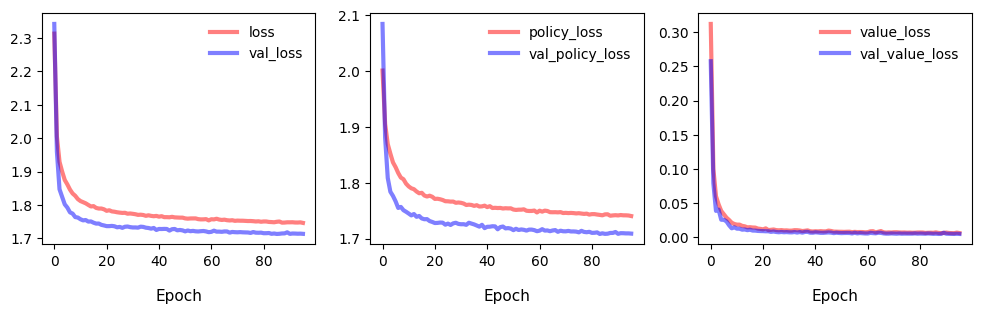

In [96]:

monitor_pairs = [["loss"       , "val_loss"],
                 ["policy_loss", "val_policy_loss"],
                 ["value_loss" , "val_value_loss"]]

num_axes = len(monitor_pairs)
fig      = plt.figure(figsize=(4*num_axes, 3))

for ax_idx, monitor_pair in enumerate(monitor_pairs) :
    
    ax  = fig.add_subplot(1, num_axes, 1+ax_idx)
    
    ax.plot(history.history[monitor_pair[0]], "-", lw=3, c="r", alpha=0.5, label=monitor_pair[0])
    ax.plot(history.history[monitor_pair[1]], "-", lw=3, c="b", alpha=0.5, label=monitor_pair[1])
    ax.legend(loc="upper right", frameon=False, fontsize=10)
    
    ax.set_xlabel("Epoch", labelpad=15, fontsize=11, ha="center", va="top")
    
plt.show(fig)
plt.close(fig)

In [111]:

if len(old_model_name) > 0 :
    old_model = load_model(old_model_name)
    bot_old = Bot_NeuralMCTS(old_model, greedy=True)
else :
    bot_old = Bot_VanillaMCTS(greedy=True)
bot = Bot_NeuralMCTS(new_model, greedy=True)

game_board = GameBoard()
while not game_board.get_result() :
    if game_board.to_play == BinaryPlayer.X :
        action = bot.choose_action(game_board, duration=1, discount=0.99, debug_lvl=DebugLevel.LOW)
    else :
        action = bot.choose_action(game_board, duration=1, discount=0.99, debug_lvl=DebugLevel.LOW)
    print("Prior values:  " + "  ".join([f"{x.prior_value:.3f}" for x in bot.root_node.children]))
    game_board.apply_action(action)
    print(game_board)
    

Selecting greedy action
Action values are:  0.035   0.150   0.564   0.777   0.184   0.223   0.007 
Visit counts are:   2       4       20      285     5       5       3     
Selecting action 3
Prior values:  0.841  0.902  0.909  0.869  0.881  0.864  0.853
+---+---+---+---+---+---+---+
| . | . | . | . | . | . | . |
| . | . | . | . | . | . | . |
| . | . | . | . | . | . | . |
| . | . | . | . | . | . | . |
| . | . | . | . | . | . | . |
| . | . | . | X | . | . | . |
+---+---+---+---+---+---+---+
| 0 | 1 | 2 | 3 | 4 | 5 | 6 |
+---+---+---+---+---+---+---+
Game result is: NONE
Selecting greedy action
Action values are:  -0.912  -0.784  -0.758  -0.812  -0.860  -0.856  -0.896
Visit counts are:   5       47      178     52      26      17      5     
Selecting action 2
Prior values:  0.872  0.852  0.768  0.826  0.836  0.788  0.878
+---+---+---+---+---+---+---+
| . | . | . | . | . | . | . |
| . | . | . | . | . | . | . |
| . | . | . | . | . | . | . |
| . | . | . | . | . | . | . |
| . | . | . | . |


KeyboardInterrupt

